# Metocean Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import xarray as xr
import distributed

In [2]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:44599 Dashboard: http://127.0.0.1:45023,Cluster Workers: 4 Cores: 4 Memory: 8.27 GB


# CANADIAN DATA

## GIOPS

http://dd.weather.gc.ca/model_giops/doc/README_GIOPS.txt

- votemper:	Potential temperature of sea water at the first model level
- vozocrtx:	X-component of water velocity at the first model level
- vomecrty:	Y-component of water velocity at the first model level

## RIOPS

- from July 17, 2016 to present

### Multi-files with daily mean

In [ ]:
ncfiles = []
for i in range(15, 31):
    riops_url = 'http://navigator.oceansdata.ca/thredds/dodsC/riops/daily/201706{}_2D.nc'.format(i)
    ncfiles.append(riops_url)

In [ ]:
riops_ds = xr.open_mfdataset(ncfiles, chunks={'yc':400, 'xc':400})

In [ ]:
riops_ds

In [ ]:
riops_ds.Conventions

In [ ]:
riops_ds.time

In [ ]:
(np.sqrt((riops_ds.vomecrty.isel(time=0).sel(xc=slice(7.6e6-1, 8.2e6-1),
                              yc=slice(2e6-1, 2.6e6-1))**2 + 
riops_ds.vozocrtx.isel(time=0).sel(xc=slice(7.6e6-1, 8.2e6-1),
                              yc=slice(2e6-1, 2.6e6-1))**2))).plot(vmin=-1, vmax=1)

### Download .nc file and remap using CDO

- Download .nc file
```bash
wget http://navigator.oceansdata.ca/thredds/fileServer/riops/riopsf/2016061500_003_2D_nps.nc
```

- Make template
- -54,-44,44,54 is min lon, max lon, min lat, max lat
- r4320x2160 is a regular grid at 1/12th degree resolution
- template.nc is out file to be created

```bash
cdo -f nc -sellonlatbox,-54,-44,44,54 -remapcon,r4320x2160 -topo template.nc
```

- Remap using bilinear
- 2016061500_003_2D_nps.nc is in file
- 2016061500_003_2D_nps_out.nc is out file to be created

```bash
cdo -f nc -remapbil,template.nc 2016061500_003_2D_nps.nc 2016061500_003_2D_nps_out.nc
```

- Inspect

```bash
ncdump -v lon 2016061500_003_2D_nps_out.nc |less
```

In [17]:
ds = nc.Dataset('/home/evankielley/Downloads/2016061500_003_2D_nps_out.nc')

In [45]:
vom = np.asarray(ds.variables['vomecrty'][0,:,:])
voz = np.asarray(ds.variables['vozocrtx'][0,:,:])

In [46]:
vom.shape

(120, 121)

In [34]:
v_mag = np.sqrt(np.asarray(ds.variables['vomecrty'][0,:,:]) + np.asarray(ds.variables['vozocrtx'][0,:,:]))

/home/evankielley/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [61]:
for i,i2 in enumerate(vom[:,0]):
    for j,j2 in enumerate(vom[0,:]):
        if vom[i,j] >= 1e2:
            vom[i,j] = np.nan

In [63]:
for i,i2 in enumerate(voz[:,0]):
    for j,j2 in enumerate(voz[0,:]):
        if voz[i,j] >= 1e2:
            voz[i,j] = np.nan

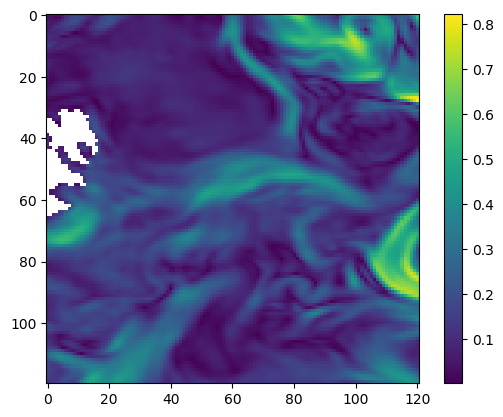

In [64]:
plt.imshow(np.sqrt(vom**2 + voz**2))
plt.colorbar()

### Multi-files with 6hr data

In [16]:
ncfiles = ['http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091906_006_3D_nps.nc',
           'http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091912_006_3D_nps.nc',
           'http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091918_006_3D_nps.nc']

In [ ]:
ds = xr.open_mfdataset(ncfiles, chunks={'depth':10, 'yc':400, 'xc':400})

In [ ]:
ds.vomecrty

In [ ]:
vx = ds.vozocrtx.isel(depth=0).sel(xc=slice(6e6-1, 8e6-1),
                              yc=slice(2e6-1, 4e6-1))
vynp.asarray(vom) = ds.vomecrty.isel(depth=0).sel(xc=slice(6e6-1, 8e6-1),
                              yc=slice(2e6-1, 4e6-1))

In [ ]:
v = np.sqrt(vx**2+vy**2)

In [ ]:
v

In [ ]:
v.isel(time=2).plot(vmax=0.8)

In [ ]:
ds.latitude.sel(xc=slice(6e6, 8e6), yc=slice(2e6, 4e6))

# AMERICAN DATA

## NOMADS - GFS

- 3 hour

In [ ]:
gfs_url ='https://www.ncei.noaa.gov/thredds/dodsC/gfs-g4-anl-files/201512/20151231/gfsanl_4_20151231_1800_006.grb2'

In [ ]:
gfs_ds = xr.open_dataset(gfs_url)

In [ ]:
gfs_ds

In [ ]:
u_wind = gfs_ds.__getitem__('u-component_of_wind_height_above_ground')
v_wind = gfs_ds.__getitem__('v-component_of_wind_height_above_ground')

In [ ]:
u_wind.dims

## GOCD

- up to 2013

In [ ]:
gocd_url = 'https://data.nodc.noaa.gov/thredds/dodsC/gocd/a0123302/gocd_a0123302_01961v3.nc'

In [ ]:
gocd_ds = xr.open_dataset(gocd_url)

In [ ]:
gocd_ds.time

## OSCAR

- 1/3 degree 

In [ ]:
oscar_url = 'https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel2015.nc.gz'

In [ ]:
oscar_ds = xr.open_dataset(oscar_url)

## HYCOM GLB V0.08

In [ ]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'

In [ ]:
glb_ds = xr.open_dataset(glb_url, decode_times=False)

In [ ]:
glb_ds.time.units

In [ ]:
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, lat = slice(47., 49.), lon = slice(-51., -49.), time=slice(135120., 135840.))

In [ ]:
glb_ds

In [ ]:
water_u = glb_ds.water_u
water_v = glb_ds.water_v
water_temp = glb_ds.water_temp

In [ ]:
water_u

## ECCO (WVEL)

- up to 2013
- 1/4 degree
- 3-day average

In [ ]:
ecco_url = 'http://harbor.mit.edu:8180/thredds/dodsC/las/ecco2.jpl.nasa.gov/cube92/quart_90S_90N/WVEL.nc/WVEL.1440x720x50.20120814.nc'

In [ ]:
ecco_ds = xr.open_dataset(ecco_url)

In [ ]:
ecco_ds

## Globcurrent

- up to 2014

In [ ]:
globcurrent_url = 'http://www.ifremer.fr/opendap/cerdap1/globcurrent/v2.0/global_012_deg/geostrophic/2014/001/20140101000000-GLOBCURRENT-L4-CURgeo_0m-ALT_OI-v02.0-fv01.0.nc'

In [ ]:
globcurrent_ds = xr.open_dataset(globcurrent_url)

In [ ]:
globcurrent_ds

## NOMADS RTOFS

- 1 hour

http://polar.ncep.noaa.gov/mmab/papers/tn284/v211p211.pdf

https://data.nodc.noaa.gov/thredds/catalog/ncep/rtofs/catalog.html

In [ ]:
rotfs_url = 'https://data.nodc.noaa.gov/thredds/dodsC/ncep/rtofs/2015/201512/ofs.20151231/surface/ofs_atl.t00z.n000.20151231.grb.grib2'

In [ ]:
rotfs_ds = xr.open_dataset(rotfs_url)

In [ ]:
rotfs_ds

In [ ]:
rotfs_ds.Longitude_of_U_Wind_Component_of_Velocity[:10,:10]

In [ ]:
v_current = rotfs_ds.__getitem__('V-component_of_current')
u_current = rotfs_ds.__getitem__('U-component_of_current')
n3d_temperature = rotfs_ds.__getitem__('N3-D_Temperature')

In [ ]:
v_current.dims

In [ ]:
n3d_temperature.dims

### Convert lon, lat to x, y

### Old Examples

In [ ]:
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:9090/dods/rtofs/rtofs_global20180111/rtofs_glo_2ds_forecast_3hrly_diag',
                       chunks={'lat':400, 'lon':400, 'time':10})

In [ ]:
ds

In [ ]:
ds.ssh.isel(time=0).plot()

## Local Files

In [ ]:
import netCDF4 as nc

In [ ]:
help(nc.Dataset) 

In [ ]:
nc_file = nc.Dataset('/home/evankielley/Downloads/expt_56.3.nc')

In [ ]:
nc_file.variables['water_u']

In [ ]:
nc_file.variables['time'][:]

## NAVGEM

- 12 hr
- 0.5 degree

In [ ]:
url = 'http://usgodae.org/dods/GDS/navgem/NAVGEM_0100_010132-000000wnd_ucmp'

In [ ]:
url = 'http://usgodae.org/dods/GDS/navgem/NAVGEM_0105_000100-000000wnd_ucmp'

In [ ]:
ds = xr.open_dataset(url)

In [ ]:
ds

In [ ]:
ds['time']

In [ ]:
ds.ugrd10m_10

In [ ]:
ds.ugrd10m_10.sel(time='2013-02-13')[0,:10,:10]

## ERDAP NAVGEM

In [ ]:
url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'

In [ ]:
ds = xr.open_dataset(url)

In [ ]:
ds

In [ ]:
ds['time']

In [ ]:
ds.sel(time=slice('2015-06-01','2015-07-01'), longitude=slice(-52,-49), latitude=slice(47,49))